In [1]:
#----------------------------
# import libraries
#----------------------------
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def create_input_x(x_raw, K):
    size = len(x_raw)
    x_out = np.zeros(shape=(size,K))
    for N in range(K, size):
        for i in range(K):
            x_out[N][i] = x_raw[N-i-1]
    return x_out

In [3]:
def reserve_test_set(data, N):
    size = len(data)
    test_set = x[(size-N):size]
    data = data[:-365]
    return data, test_set

In [4]:
def temporal_kfold(x, y, K, folds):
    x = np.array_split(x, folds)
    y = np.array_split(y, folds)
    # start fold_0 array
    fold_x = [x[0]]
    fold_y = [y[0]]
    # remove first K data from first fold
    fold_x[0] = fold_x[0][K:]
    fold_y[0] = fold_y[0][K:]
    # start validation array
    val_x = [x[1]]
    val_y = [y[1]]
    for i in range(1, folds - 1):
        #fold_x[i] = fold_x[i-1] concat x[i]
        fold_x.append( np.concatenate((fold_x[i-1], x[i]), axis=0) )
        fold_y.append( np.concatenate((fold_y[i-1], y[i]), axis=0) )
        # validation array
        val_x.append( x[i+1] )
        val_y.append( y[i+1] )
    return fold_x, fold_y, val_x, val_y

In [5]:
def pseudoinverse(y, phi, alpha):
    # identity matrix (with first element = 0) used for rigde regression
    I = np.identity(phi.shape[1])
    I[0][0] = 0
    w = np.linalg.inv( (phi.T @ phi) + (alpha * I) ) @ phi.T @ y
    #w = np.linalg.inv( phi.T @ phi) @ phi.T @ y
    return w

In [6]:
def calc_error(x, y, w):
    phi = np.insert(x, 0, [1], axis=1)
    ŷ = phi @ w
    e = y - ŷ
    rmse = np.sqrt( np.mean(e*e) )
    return rmse

In [7]:
def train(x, y, K, F, alpha):
    if (F == 1):
        phi = np.insert(x, 0, [1], axis=1)
        w = pseudoinverse(y, phi, alpha)
        error = calc_error(x, y, w)
    else:
        # k-fold cross-validation
        fold_x, fold_y, val_x, val_y = temporal_kfold(x, y, K, F)
        # training the model
        error = np.zeros(shape=(F-1, 1))
        w = np.zeros(shape=(K, 1))
        # calculate w and error for each fold
        for j in range(F-1):
            phi = np.insert(fold_x[j], 0, [1], axis=1)
            w = pseudoinverse(fold_y[j], phi, alpha)
            error[j] = calc_error(val_x[j], val_y[j], w)
    error_mean = np.mean(error)
    return w, error_mean

In [8]:
#-----------------------------
# manipulating data
#-----------------------------
# read csv file
df = pd.read_csv('daily-minimum-temperatures.csv')
date = df['Date'].values
temp = df['Temp'].values
size = len(date)
#------------------
# input data
x_raw = temp[:-365]
y = np.array([temp]).T
y = y[:-365]
#------------------
# path to save figures
path = 'Figures/figures ex1/'

In [9]:
# definitions
days = 31
folds = 9
w = days * [0]
e = days * [0]
for K in range(1,days+1):
    x = create_input_x(x_raw, K)
    w[K-1], e[K-1] = train(x, y, K, folds, alpha=0)

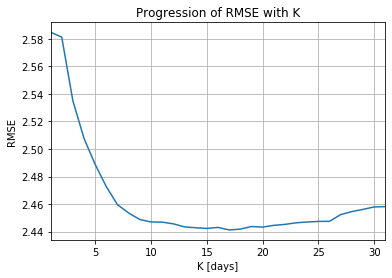

In [10]:
# plots
plt.plot(range(1,days+1), e)
# axis label
plt.xlabel('K [days]')
plt.ylabel('RMSE')
# axis adjust
plt.autoscale(axis='x', tight=True)
# title
plt.title('Progression of RMSE with K')
# add grid
plt.grid(True)
plt.savefig(path + 'figure 1 - progression of rmse with k.png', dpi=300)
plt.show()

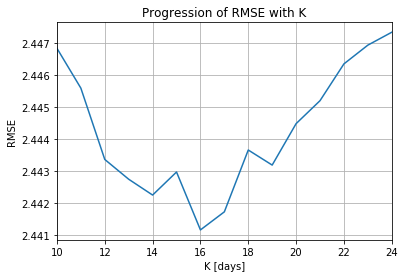

In [11]:
# plots
plt.plot(range(10,25), e[10:25])
# axis label
plt.xlabel('K [days]')
plt.ylabel('RMSE')
# axis adjust
plt.autoscale(axis='x', tight=True)
# title
plt.title('Progression of RMSE with K')
# add grid
plt.grid(True)
plt.savefig(path + 'figure 2 - progression of rmse with k (zoomed).png', dpi=300)
plt.show()

In [12]:
K = e.index(min(e))
x = create_input_x(x_raw, K)
w, e = train(x, y, K, F=1, alpha=0)
print('K for minimun error =', K)

K for minimun error = 16


In [13]:
# test set (x)
ts_x = create_input_x(temp, K)[-365:]
# test set (y)
y = np.array([temp]).T
ts_y = y[-365:]

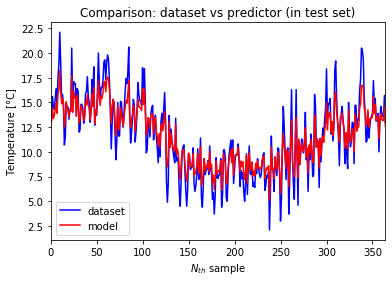

In [14]:
phi = np.insert(ts_x, 0, [1], axis=1)
ŷ = phi @ w
# reserve test set
ts = temp[-365:]
# plots
plt.plot(ts,'b', label='dataset')
#plt.plot(ŷ,'r', label='model')
plt.plot(np.roll(ŷ,-1),'r', label='model')
# axis label
plt.xlabel(r'$N_{th}$ sample')
plt.ylabel('Temperature [°C]')
# title
plt.title('Comparison: dataset vs predictor (in test set)')
plt.autoscale(axis='x', tight=True)
plt.legend()
plt.savefig(path + 'figure 3 - dataset vs predictor.png', dpi=300)
plt.show()

In [15]:
#e = ts_y - ŷ
e = ts_y - np.roll(ŷ,-1)
error = calc_error(ts_x, ts_y, w)
print('RMSE = ', error)

RMSE =  2.2793348397115585
